# Intelligent Flow: Leveraging Machine Learning  for Urban Traffic Management

## Project Objective and Goal:
The main goal is to leverage machine learning techniques to enhance urban traffic management in Heidelberg by predicting traffic intensity through various locations and times.

## Research Question:
How can we accurately predict traffic intensity variations across different times and locations in Heidelberg using machine learning models?

## Machine Learning Aim:
To apply and evaluate SARIMAX and Prophet models on traffic data, tuned to predict daily, weekly, and business-day traffic intensities effectively, thereby assisting in better urban planning and congestion management.

## Dataset 
Traffic cameras in the city of Heidelberg
The dataset contains an observation of the traffic flow at a specific place and time. It contains current and past measurements from traffic cameras in the city of Heidelberg (measurement interval: 15 min).
In addition to general location information, each dataset contains, if available, information on the number of vehicles and vehicle types measured, the average distance between vehicles and their passing time.
A detailed description of the dataset,the specification, and the raw data can be found here: 
https://ckan.datenplattform.heidelberg.de/de/dataset/mobility_main_trafficcamera
<br>In the accuired traffic data the volume of traffic is represented as the count of the number of vehicles passing every 15 mins. Traffic volumes, during the morning weekday rush hour, are used as an illustrative example: plot 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot

import seaborn as sns
import plotly.express as px
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima

# statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# skforecast
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from sklearn.metrics import mean_absolute_error

import warnings

from sklearn.metrics import mean_squared_error
from math import sqrt

import prophet
from prophet import Prophet
from scipy.stats import uniform
import mango
from mango import Tuner, scheduler


import pmdarima as pm
%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
lesing_Straße ='dc5200b1-8783-4800-82cb-4f5718c00581.csv'
data = pd.read_csv(lesing_Straße)
data

,_id,recvTime,fiwareServicePath,entityId,entityType,averageVehicleSpeed,occupancy,latitude,postalCode,description,...,alternateName,dateObservedFrom,congested,reversedLane,intensity,laneId,streetAddress,refRoadSegment,name,dataProvider
0,1,2022-11-03T14:05:20.287Z,/main/trafficcamera,urn:ngsiv2:TrafficFlowObserved:8ef25839-7e73-4...,TrafficFlowObserved,NaN,NaN,49.399801,69124,NaN,...,NaN,2022-11-03T13:40:00.000Z,NaN,NaN,5,NaN,Lessingstraße 12,NaN,NaN,NaN
1,2,2022-11-03T14:05:20.292Z,/main/trafficcamera,urn:ngsiv2:TrafficFlowObserved:8ef25839-7e73-4...,TrafficFlowObserved,NaN,NaN,49.399801,69124,NaN,...,NaN,2022-11-03T13:40:00.000Z,NaN,NaN,134,NaN,Lessingstraße 12,NaN,NaN,NaN
2,3,2022-11-03T14:05:20.388Z,/main/trafficcamera,urn:ngsiv2:TrafficFlowObserved:8ef25839-7e73-4...,TrafficFlowObserved,NaN,NaN,49.399801,69124,NaN,...,NaN,2022-11-03T13:40:00.000Z,NaN,NaN,4,NaN,Lessingstraße 12,NaN,NaN,NaN
3,4,2022-11-03T14:05:20.410Z,/main/trafficcamera,urn:ngsiv2:TrafficFlowObserved:8ef25839-7e73-4...,TrafficFlowObserved,NaN,NaN,49.399801,69124,NaN,...,NaN,2022-11-03T13:40:00.000Z,NaN,NaN,10,NaN,Lessingstraße 12,NaN,NaN,NaN
4,5,2022-11-03T14:15:08.715Z,/main/trafficcamera,urn:ngsiv2:TrafficFlowObserved:8ef25839-7e73-4...,TrafficFlowObserved,NaN,NaN,49.399801,69124,NaN,...,NaN,2022-11-03T13:55:00.000Z,NaN,NaN,131,NaN,Lessingstraße 12,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100685,101106,2024-03-04T23:15:07.768Z,/main/trafficcamera,urn:ngsiv2:TrafficFlowObserved:8ef25839-7e73-4...,TrafficFlowObserved,NaN,NaN,49.399801,69124,NaN,...,NaN,2024-03-04T22:55:00.000Z,NaN,NaN,1,NaN,Lessingstraße 12,NaN,NaN,NaN
100686,101107,2024-03-04T23:15:08.244Z,/main/trafficcamera,urn:ngsiv2:TrafficFlowObserved:8ef25839-7e73-4...,TrafficFlowObserved,NaN,NaN,49.399801,69124,NaN,...,NaN,2024-03-04T22:55:00.000Z,NaN,NaN,0,NaN,Lessingstraße 12,NaN,NaN,NaN
100687,101108,2024-03-04T23:30:07.776Z,/main/trafficcamera,urn:ngsiv2:TrafficFlowObserved:8ef25839-7e73-4...,TrafficFlowObserved,NaN,NaN,49.399801,69124,NaN,...,NaN,2024-03-04T23:10:00.000Z,NaN,NaN,1,NaN,Lessingstraße 12,NaN,NaN,NaN
100688,101109,2024-03-04T23:45:07.964Z,/main/trafficcamera,urn:ngsiv2:TrafficFlowObserved:8ef25839-7e73-4...,TrafficFlowObserved,NaN,NaN,49.399801,69124,NaN,...,NaN,2024-03-04T23:25:00.000Z,NaN,NaN,2,NaN,Lessingstraße 12,NaN,NaN,NaN


### Initial analysis and data wrangling 

In [37]:
null =[col for col in data.columns if data[col].isna().sum() == data.shape[0]]
data = data.drop(columns = null)

In [38]:
col_to_check = ['fiwareServicePath','entityId','entityType','addressLocality','addressCountry']
for col in col_to_check:
    print(data[col].unique())

['/main/trafficcamera']
['urn:ngsiv2:TrafficFlowObserved:8ef25839-7e73-408a-8025-89b2e1bc01b6']
['TrafficFlowObserved']
['Heidelberg']
['Deutschland']


In [39]:
data = data.drop(columns = col_to_check) 

In [40]:
data.head(4)

,_id,recvTime,latitude,postalCode,vehicleType,longitude,dateObservedTo,dateObserved,dateObservedFrom,intensity,streetAddress
0,1,2022-11-03T14:05:20.287Z,49.399801,69124,motorcycle,8.682942,2022-11-03T13:55:00.000Z,2022-11-03T13:55:00.000Z,2022-11-03T13:40:00.000Z,5,Lessingstraße 12
1,2,2022-11-03T14:05:20.292Z,49.399801,69124,car,8.682942,2022-11-03T13:55:00.000Z,2022-11-03T13:55:00.000Z,2022-11-03T13:40:00.000Z,134,Lessingstraße 12
2,3,2022-11-03T14:05:20.388Z,49.399801,69124,van,8.682942,2022-11-03T13:55:00.000Z,2022-11-03T13:55:00.000Z,2022-11-03T13:40:00.000Z,4,Lessingstraße 12
3,4,2022-11-03T14:05:20.410Z,49.399801,69124,lorry,8.682942,2022-11-03T13:55:00.000Z,2022-11-03T13:55:00.000Z,2022-11-03T13:40:00.000Z,10,Lessingstraße 12


In [41]:
data = data.drop_duplicates()
data = data.reset_index(drop =True)

#### Converting formats

In [42]:
# Converting the types
data['recvTime'] = pd.to_datetime(data['recvTime'])
data['dateObserved'] = pd.to_datetime(data['dateObserved'])
data['dateObservedFrom'] = pd.to_datetime(data['dateObservedFrom'])
data['dateObservedTo'] = pd.to_datetime(data['dateObservedTo'])

In [43]:
data['hourOfDay'] = data['dateObserved'].dt.hour
data['date'] = data['dateObserved'].dt.date
data['year'] = pd.DatetimeIndex(data['date']).year
data['month'] = pd.DatetimeIndex(data['date']).month
data['days_of_week'] = pd.DatetimeIndex(data['date']).day_name()
data['date'] =pd.to_datetime(data['date'])

In [44]:
data.dtypes

_id                               int64
recvTime            datetime64[ns, UTC]
latitude                        float64
postalCode                        int64
vehicleType                      object
longitude                       float64
dateObservedTo      datetime64[ns, UTC]
dateObserved        datetime64[ns, UTC]
dateObservedFrom    datetime64[ns, UTC]
intensity                         int64
streetAddress                    object
hourOfDay                         int32
date                     datetime64[ns]
year                              int32
month                             int32
days_of_week                     object
dtype: object

In [45]:
data[data['date']== '2022-11-09'].head(15)

,_id,recvTime,latitude,postalCode,vehicleType,longitude,dateObservedTo,dateObserved,dateObservedFrom,intensity,streetAddress,hourOfDay,date,year,month,days_of_week
1556,1557,2022-11-09 06:45:08.166000+00:00,49.399801,69124,car,8.682942,2022-11-09 06:40:00+00:00,2022-11-09 06:40:00+00:00,2022-11-09 06:25:00+00:00,169,Lessingstraße 12,6,2022-11-09,2022,11,Wednesday
1557,1558,2022-11-09 06:45:08.176000+00:00,49.399801,69124,motorcycle,8.682942,2022-11-09 06:40:00+00:00,2022-11-09 06:40:00+00:00,2022-11-09 06:25:00+00:00,17,Lessingstraße 12,6,2022-11-09,2022,11,Wednesday
1558,1559,2022-11-09 06:45:08.194000+00:00,49.399801,69124,van,8.682942,2022-11-09 06:40:00+00:00,2022-11-09 06:40:00+00:00,2022-11-09 06:25:00+00:00,2,Lessingstraße 12,6,2022-11-09,2022,11,Wednesday
1559,1560,2022-11-09 06:45:08.203000+00:00,49.399801,69124,lorry,8.682942,2022-11-09 06:40:00+00:00,2022-11-09 06:40:00+00:00,2022-11-09 06:25:00+00:00,4,Lessingstraße 12,6,2022-11-09,2022,11,Wednesday
1560,1561,2022-11-09 07:00:07.309000+00:00,49.399801,69124,car,8.682942,2022-11-09 06:55:00+00:00,2022-11-09 06:55:00+00:00,2022-11-09 06:40:00+00:00,190,Lessingstraße 12,6,2022-11-09,2022,11,Wednesday
1561,1562,2022-11-09 07:00:07.321000+00:00,49.399801,69124,motorcycle,8.682942,2022-11-09 06:55:00+00:00,2022-11-09 06:55:00+00:00,2022-11-09 06:40:00+00:00,25,Lessingstraße 12,6,2022-11-09,2022,11,Wednesday
1562,1563,2022-11-09 07:00:07.378000+00:00,49.399801,69124,lorry,8.682942,2022-11-09 06:55:00+00:00,2022-11-09 06:55:00+00:00,2022-11-09 06:40:00+00:00,3,Lessingstraße 12,6,2022-11-09,2022,11,Wednesday
1563,1564,2022-11-09 07:00:07.475000+00:00,49.399801,69124,van,8.682942,2022-11-09 06:55:00+00:00,2022-11-09 06:55:00+00:00,2022-11-09 06:40:00+00:00,1,Lessingstraße 12,6,2022-11-09,2022,11,Wednesday
1682,1683,2022-11-09 07:30:18.968000+00:00,49.399801,69124,car,8.682942,2022-11-09 07:25:00+00:00,2022-11-09 07:25:00+00:00,2022-11-09 07:10:00+00:00,230,Lessingstraße 12,7,2022-11-09,2022,11,Wednesday
1683,1684,2022-11-09 07:30:18.993000+00:00,49.399801,69124,motorcycle,8.682942,2022-11-09 07:25:00+00:00,2022-11-09 07:25:00+00:00,2022-11-09 07:10:00+00:00,19,Lessingstraße 12,7,2022-11-09,2022,11,Wednesday


#### Gap Handling Strategy:

Isolated Gaps: Replace missing values (NA) with interpolated values using the interpolate() function.

Several Consecutive Gaps: Fill the gaps by repeating the time-series values from the past within the same period.

#####  Checking for gaps in time series 

In [46]:
data_timegrouped = data.groupby('dateObserved')[['intensity']].sum()
data_timegrouped

,intensity
dateObserved,
2022-11-03 13:55:00+00:00,153
2022-11-03 14:10:00+00:00,145
2022-11-03 14:25:00+00:00,157
2022-11-03 14:40:00+00:00,137
2022-11-03 14:55:00+00:00,175
...,...
2024-03-04 22:25:00+00:00,3
2024-03-04 22:40:00+00:00,1
2024-03-04 23:10:00+00:00,1


In [47]:
gap = data_timegrouped.asfreq('15min')
gap.isna().sum()

intensity    14421
dtype: int64

In [48]:
mask = gap.isna().any(axis=1)
gap_final = gap.loc[mask,'intensity']
gap_final = pd.DataFrame(gap_final)
gap_final

,intensity
dateObserved,
2022-11-03 15:55:00+00:00,NaN
2022-11-07 01:10:00+00:00,NaN
2022-11-09 01:40:00+00:00,NaN
2022-11-09 04:55:00+00:00,NaN
2022-11-09 07:10:00+00:00,NaN
...,...
2024-03-04 06:40:00+00:00,NaN
2024-03-04 06:55:00+00:00,NaN
2024-03-04 07:55:00+00:00,NaN


In [49]:
gap_reset = gap.reset_index()
gap_reset['dateObserved'] = pd.to_datetime(gap_reset['dateObserved'])
gap_reset['date']=gap_reset['dateObserved'].dt.date

Text(0, 0.5, 'Average Traffic Intensity')

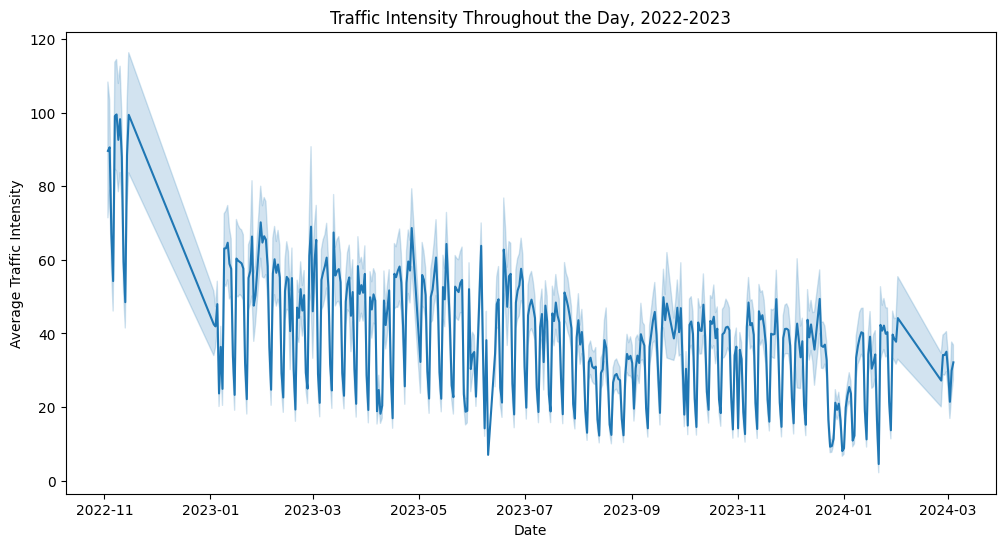

In [50]:
gap_reset['date'] = pd.to_datetime(gap_reset['dateObserved']).dt.normalize()

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='intensity', data=gap_reset)
plt.title("Traffic Intensity Throughout the Day, 2022-2023")
plt.xlabel('Date')
plt.ylabel('Average Traffic Intensity')


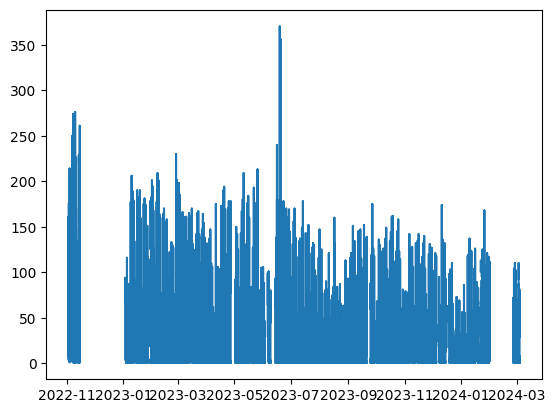

In [51]:
plt.plot(gap_reset.date, gap_reset.intensity)

##### Considering one year cycle 

In [52]:
data2022 = data[data['year'] == 2022]
datafil = data[(data['year'] == 2023) | (data['year'] == 2024) & (data['date'] < '2024-01-03')]

datafil_grouped_23_24 = datafil.groupby('dateObserved')[['intensity']].sum()
gap_23_24 = datafil_grouped_23_24.asfreq('15min')
print(f' After reducing the cycle to exactly one year ( 2023/01/03 - 2024/01-02) the data has {gap_23_24.isna().sum().iloc[0]} gaps.')

 After reducing the cycle to exactly one year ( 2023/01/03 - 2024/01-02) the data has 6460 gaps.


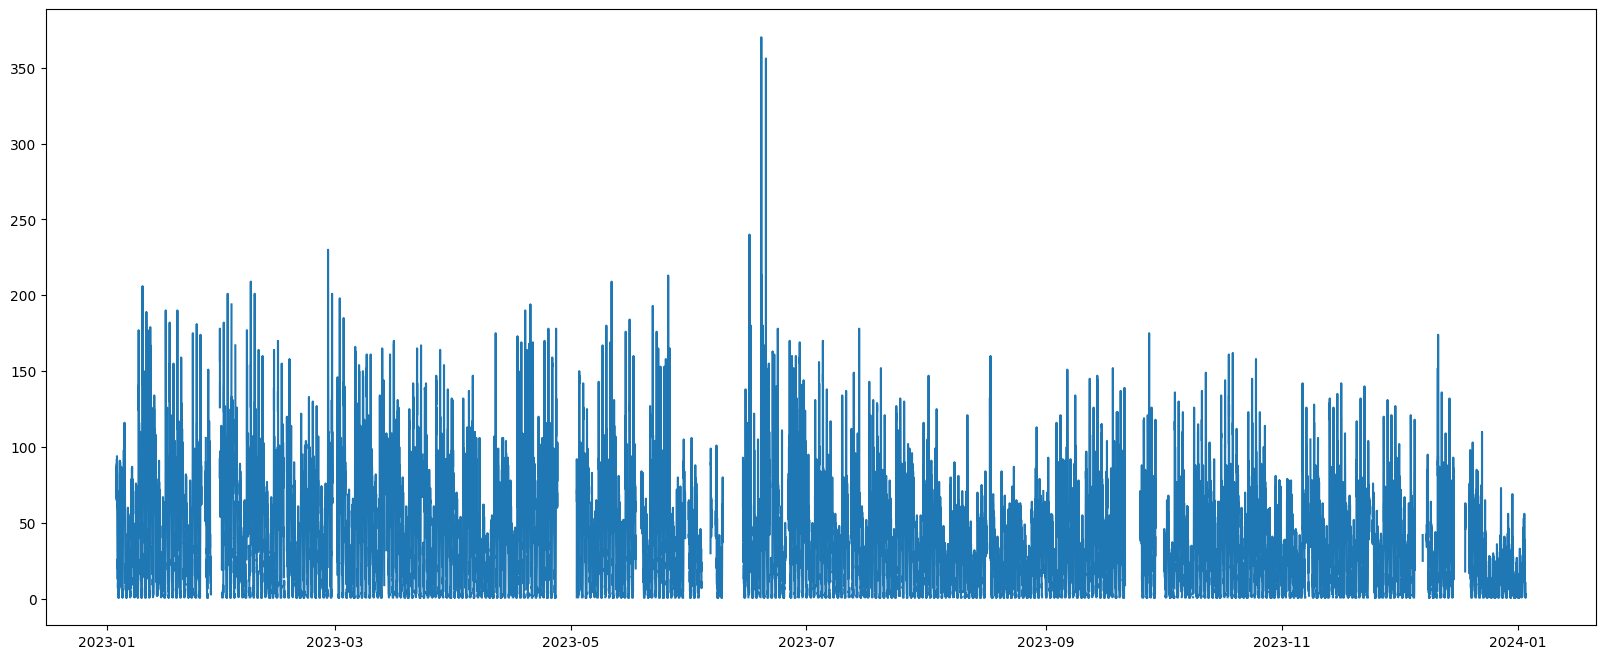

In [53]:
plt.figure(figsize=(20,8))
plt.plot(gap_23_24.index, gap_23_24.intensity)
plt.show()

In [54]:
def fill_with_previous_week(row, df):
    """
    Fill missing intensity values by replacing them with the intensity value 
    from the same weekday and time (hour and minute) in the previous week.

    Parameters:
        row (pandas.Series): A single row of the DataFrame containing intensity values.
        df (pandas.DataFrame): The DataFrame containing the intensity data.

    Returns:
        float or np.nan: The intensity value from the previous week if a match is found, 
                         otherwise np.nan.

    Notes:
        This function assumes that the index of the DataFrame 'df' is a datetime index.
        Missing intensity values are identified using pd.isna(row['intensity']).
        The function searches for a matching intensity value from the same weekday and time
        in the previous week and returns the intensity value if a match is found.
        If no match is found, np.nan is returned to indicate that the missing value could not be filled.
    """
    if pd.isna(row['intensity']):
        target_date = row.name
        print("Target Date:", target_date)  # Debug print

        #the previous week
        previous_week_start = target_date - pd.DateOffset(weeks=1)
        previous_week_end = previous_week_start + pd.DateOffset(days=6)

        # Filter the previous week + the same weekday
        previous_week_df = df[(df.index >= previous_week_start) & 
                              (df.index <= previous_week_end) &
                              (df.index.weekday == target_date.weekday())]
        
        match = previous_week_df[(previous_week_df.index.hour == target_date.hour) & 
                                 (previous_week_df.index.minute == target_date.minute)]

        print("Matches found:", len(match))  # Debug print
        
        if not match.empty:
            print("Intensity in Match:", match['intensity'].iloc[0])  # Print the intensity value in the match
            return match['intensity'].iloc[-1]  # Return the intensity from the last row of the match
        else:
            return np.nan
    else:
        return row['intensity']



def refill_with_previous_week(row, df,column):
    """
    Fill missing values in a specific column of a DataFrame row by replacing them with the corresponding 
    value from the same weekday and time (hour and minute) in the previous week.

    Parameters:
        row (pandas.Series): A single row of the DataFrame containing the data.
        df (pandas.DataFrame): The DataFrame containing the data.
        column (str): The name of the column to fill with previous week's data.

    Returns:
        float or np.nan: The value from the previous week if a match is found, 
                         otherwise np.nan.

    Notes:
        This function assumes that the index of the DataFrame 'df' is a datetime index.
        Missing values are identified using pd.isna(row[column]).
        The function searches for a matching value from the same weekday and time
        in the previous week and returns the value if a match is found.
        If no match is found, np.nan is returned to indicate that the missing value could not be filled.
    """
    if pd.isna(row[column]):
        target_date = row.name
        print("Target Date:", target_date) 

        #the previous week
        previous_week_start = target_date - pd.DateOffset(weeks=1)
        previous_week_end = previous_week_start + pd.DateOffset(days=6)

        # Filter the previous week + the same weekday
        previous_week_df = df[(df.index >= previous_week_start) & 
                              (df.index <= previous_week_end) &
                              (df.index.weekday == target_date.weekday())]
        
        match = previous_week_df[(previous_week_df.index.hour == target_date.hour) & 
                                 (previous_week_df.index.minute == target_date.minute)]

        print("Matches found:", len(match))
        
        if not match.empty:
            return match[column].iloc[-1]
        else:
            return np.nan
    else:
        return row[column]


In [55]:
gap_23_24['filled_intensity'] = gap_23_24.apply(lambda row: fill_with_previous_week(row, gap_23_24), axis=1)

Target Date: 2023-01-04 01:25:00+00:00
Matches found: 0
Target Date: 2023-01-04 02:40:00+00:00
Matches found: 0
Target Date: 2023-01-04 03:25:00+00:00
Matches found: 0
Target Date: 2023-01-04 19:25:00+00:00
Matches found: 0
Target Date: 2023-01-06 03:10:00+00:00
Matches found: 0
Target Date: 2023-01-08 10:25:00+00:00
Matches found: 0
Target Date: 2023-01-08 19:25:00+00:00
Matches found: 0
Target Date: 2023-01-08 22:40:00+00:00
Matches found: 0
Target Date: 2023-01-09 00:40:00+00:00
Matches found: 0
Target Date: 2023-01-09 00:55:00+00:00
Matches found: 0
Target Date: 2023-01-09 01:10:00+00:00
Matches found: 0
Target Date: 2023-01-09 01:40:00+00:00
Matches found: 0
Target Date: 2023-01-09 01:55:00+00:00
Matches found: 0
Target Date: 2023-01-09 02:55:00+00:00
Matches found: 0
Target Date: 2023-01-10 01:10:00+00:00
Matches found: 0
Target Date: 2023-01-10 02:25:00+00:00
Matches found: 0
Target Date: 2023-01-10 02:40:00+00:00
Matches found: 0
Target Date: 2023-01-11 01:10:00+00:00
Matches f

In [56]:
gap_23_24['filled_intensity'] = gap_23_24.apply(lambda row: refill_with_previous_week(row, gap_23_24,'filled_intensity' ), axis=1)
gap_23_24['filled_intensity'] = gap_23_24.apply(lambda row: refill_with_previous_week(row, gap_23_24,'filled_intensity' ), axis=1)

Target Date: 2023-01-04 01:25:00+00:00
Matches found: 0
Target Date: 2023-01-04 02:40:00+00:00
Matches found: 0
Target Date: 2023-01-04 03:25:00+00:00
Matches found: 0
Target Date: 2023-01-04 19:25:00+00:00
Matches found: 0
Target Date: 2023-01-06 03:10:00+00:00
Matches found: 0
Target Date: 2023-01-08 10:25:00+00:00
Matches found: 0
Target Date: 2023-01-08 19:25:00+00:00
Matches found: 0
Target Date: 2023-01-08 22:40:00+00:00
Matches found: 0
Target Date: 2023-01-09 00:40:00+00:00
Matches found: 0
Target Date: 2023-01-09 00:55:00+00:00
Matches found: 0
Target Date: 2023-01-09 01:10:00+00:00
Matches found: 0
Target Date: 2023-01-09 01:40:00+00:00
Matches found: 0
Target Date: 2023-01-09 01:55:00+00:00
Matches found: 0
Target Date: 2023-01-09 02:55:00+00:00
Matches found: 0
Target Date: 2023-01-10 01:10:00+00:00
Matches found: 0
Target Date: 2023-01-10 02:25:00+00:00
Matches found: 0
Target Date: 2023-01-10 02:40:00+00:00
Matches found: 0
Target Date: 2023-01-11 01:25:00+00:00
Matches f

In [57]:
gap_23_24['filled_intensity'].isna().sum()

803

In [58]:
mask = gap_23_24['filled_intensity'].isna()
gap_23_24_null = gap_23_24.loc[mask]
gap_23_24_null

,intensity,filled_intensity
dateObserved,,
2023-01-04 01:25:00+00:00,NaN,NaN
2023-01-04 02:40:00+00:00,NaN,NaN
2023-01-04 03:25:00+00:00,NaN,NaN
2023-01-04 19:25:00+00:00,NaN,NaN
2023-01-06 03:10:00+00:00,NaN,NaN
...,...,...
2024-01-02 00:40:00+00:00,NaN,NaN
2024-01-02 01:55:00+00:00,NaN,NaN
2024-01-02 02:40:00+00:00,NaN,NaN


In [59]:
gap_23_24['ffill_intenstiy']= gap_23_24['intensity'].ffill()
gap_23_24['bfil_intensity']=gap_23_24['intensity'].bfill()


In [60]:
mask = gap_23_24.filled_intensity.isna()
null = gap_23_24.loc[mask,:]
null

,intensity,filled_intensity,ffill_intenstiy,bfil_intensity
dateObserved,,,,
2023-01-04 01:25:00+00:00,NaN,NaN,6.0,2.0
2023-01-04 02:40:00+00:00,NaN,NaN,2.0,1.0
2023-01-04 03:25:00+00:00,NaN,NaN,4.0,1.0
2023-01-04 19:25:00+00:00,NaN,NaN,10.0,8.0
2023-01-06 03:10:00+00:00,NaN,NaN,1.0,1.0
...,...,...,...,...
2024-01-02 00:40:00+00:00,NaN,NaN,2.0,2.0
2024-01-02 01:55:00+00:00,NaN,NaN,2.0,2.0
2024-01-02 02:40:00+00:00,NaN,NaN,2.0,2.0


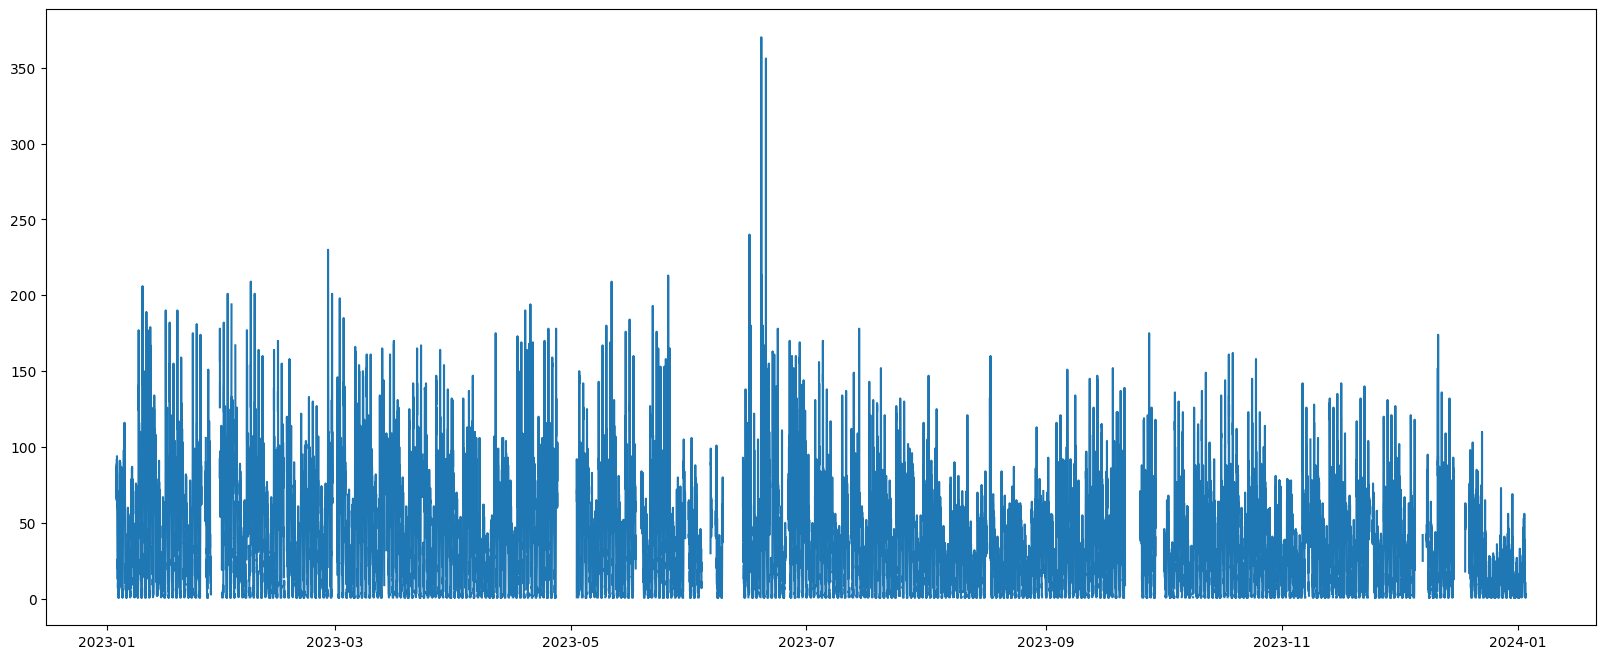

In [61]:
plt.figure(figsize=(20,8))
plt.plot(gap_23_24.index, gap_23_24.intensity)
plt.show()

In [62]:
gap_23_24[(gap_23_24.index.month == 4) & (gap_23_24.index.day > 24) &(gap_23_24.index.hour > 15) ].asfreq('D')

,intensity,filled_intensity,ffill_intenstiy,bfil_intensity
dateObserved,,,,
2023-04-25 16:10:00+00:00,94.0,94.0,94.0,94.0
2023-04-26 16:10:00+00:00,96.0,96.0,96.0,96.0
2023-04-27 16:10:00+00:00,NaN,65.0,78.0,1.0
2023-04-28 16:10:00+00:00,NaN,73.0,78.0,1.0
2023-04-29 16:10:00+00:00,NaN,66.0,78.0,1.0
2023-04-30 16:10:00+00:00,NaN,50.0,78.0,1.0


In [63]:
#gap_23_24['filled_intensity'] = gap_23_24['filled_intensity'].ffill()
gap_23_24['filled_intensity'] = gap_23_24['filled_intensity'].interpolate(method='time')
gap_23_24['filled_intensity']  = np.ceil(gap_23_24['filled_intensity'])


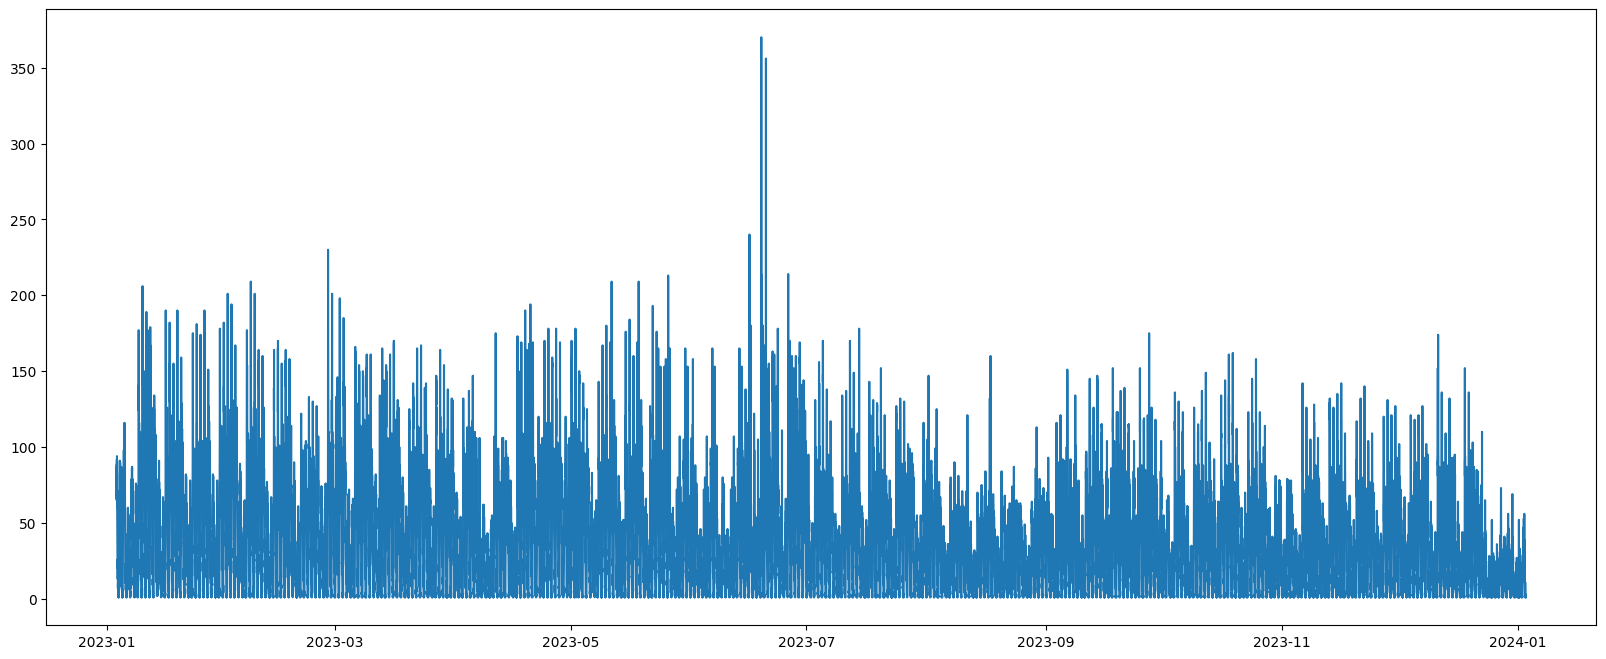

In [64]:
plt.figure(figsize=(20,8))
plt.plot(gap_23_24.index, gap_23_24.filled_intensity)
plt.show()

In [65]:
gap_23_24= gap_23_24.drop(columns = ['ffill_intenstiy','bfil_intensity'])
gap_23_24.isna().sum()

intensity           6460
filled_intensity       0
dtype: int64

In [66]:
data_preprocessed = gap_23_24.reset_index()
data_preprocessed.dtypes

dateObserved        datetime64[ns, UTC]
intensity                       float64
filled_intensity                float64
dtype: object

In [80]:
gap_23_24.to_csv('Lenstr_clean.csv')

## Exploratory Data Analysis

In [67]:
data_preprocessed['hourOfDay']=data_preprocessed['dateObserved'].dt.hour
data_preprocessed['date']=data_preprocessed['dateObserved'].dt.date
data_preprocessed['date'] = pd.to_datetime(data_preprocessed['date'])
data_preprocessed['year'] = data_preprocessed['date'].dt.year
data_preprocessed['month_number'] = data_preprocessed['date'].dt.month
data_preprocessed['month'] = data_preprocessed['date'].dt.month_name()
data_preprocessed['days_of_week'] = data_preprocessed['date'].dt.day_name()

#### Traffic intensity variation throughout the day

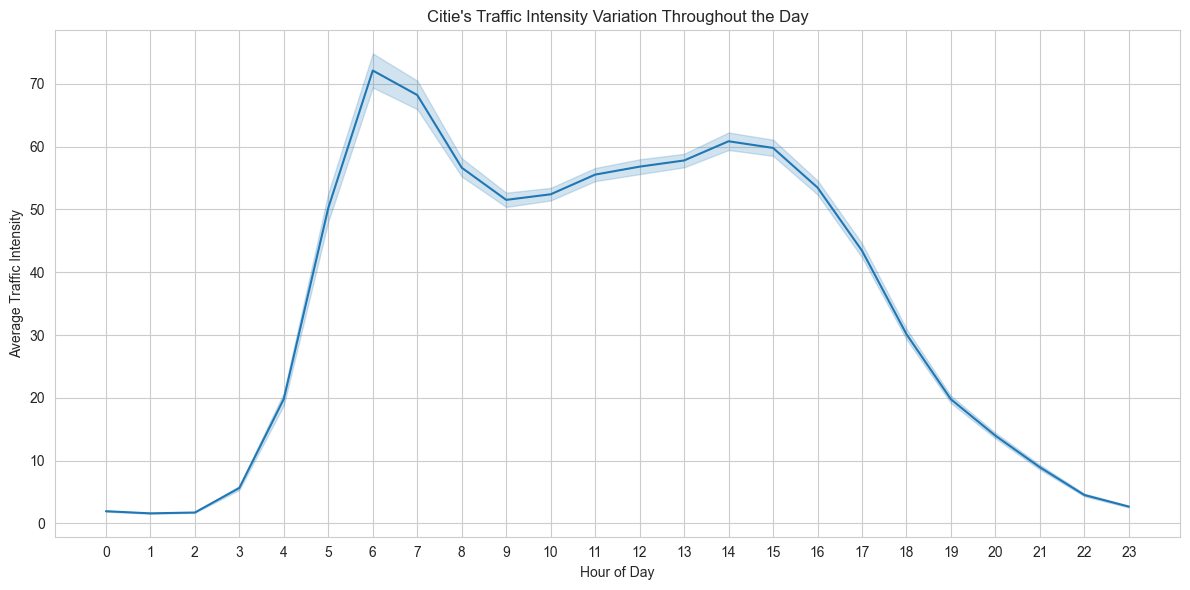

In [68]:
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
sns.lineplot(x='hourOfDay', y='filled_intensity', data=data_preprocessed, estimator='mean' )
plt.title("Citie's Traffic Intensity Variation Throughout the Day")
plt.xlabel('Hour of Day')
plt.ylabel('Average Traffic Intensity')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()

#note estimatorname : Method for aggregating across multiple observations of the y variable at the same x level. If None, all observations will be drawn.

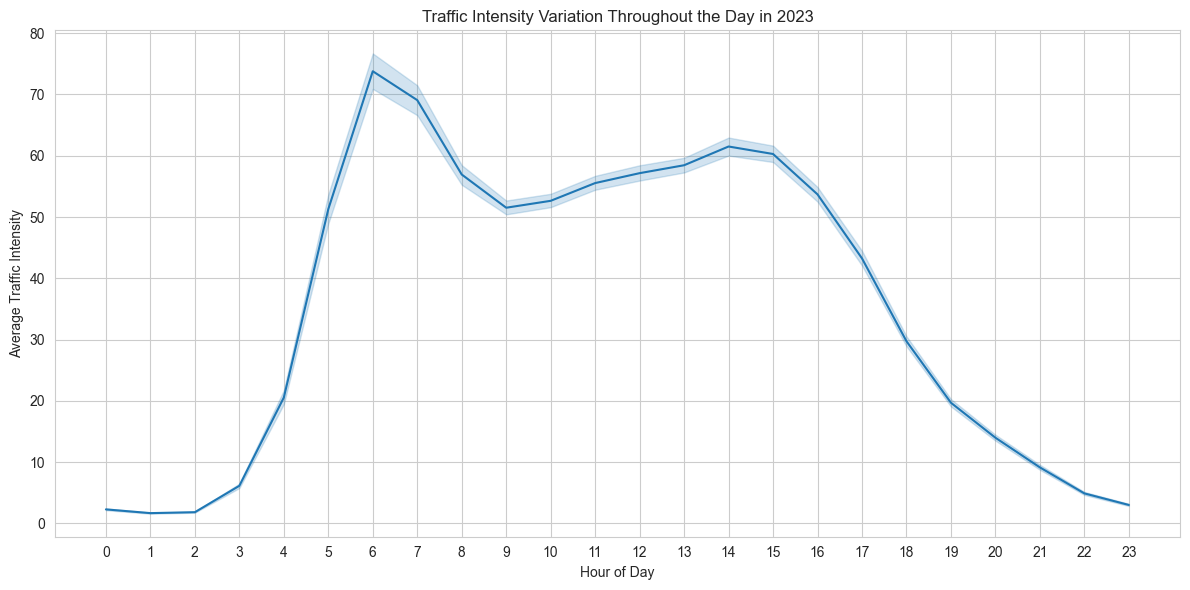

In [69]:
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
sns.lineplot(x='hourOfDay', y='intensity', data=data_preprocessed[(data_preprocessed['year']==2023)], estimator='mean')
plt.title('Traffic Intensity Variation Throughout the Day in 2023')
plt.xlabel('Hour of Day')
plt.ylabel('Average Traffic Intensity')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()


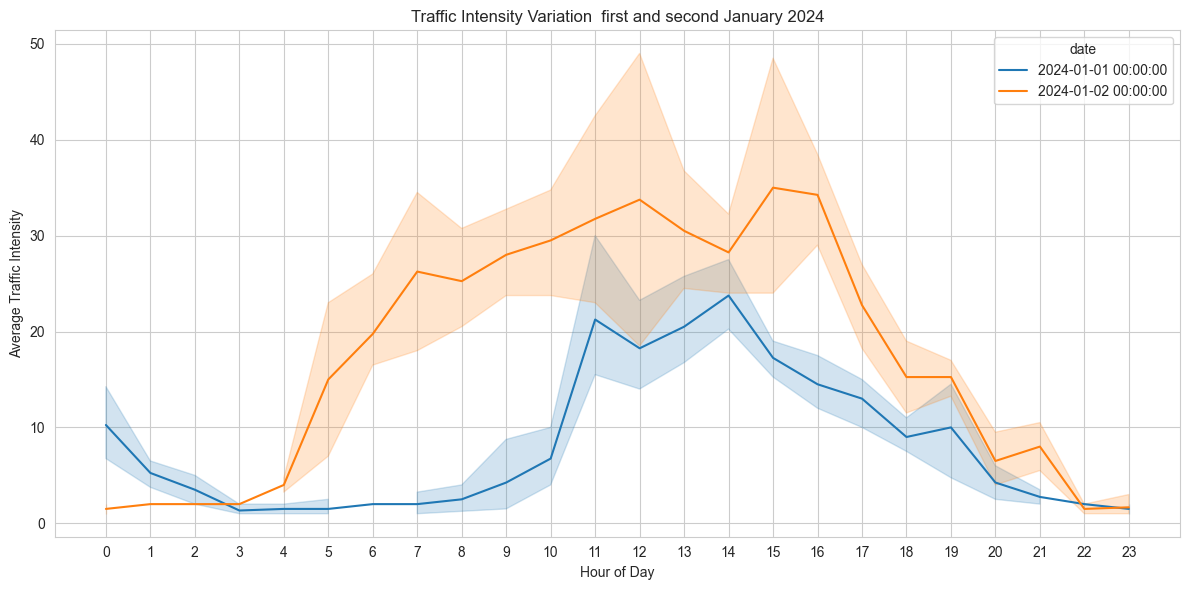

In [70]:
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
sns.lineplot(x='hourOfDay', y='intensity',hue='date', data=data_preprocessed[(data_preprocessed['year']==2024)], estimator='mean')
plt.title('Traffic Intensity Variation  first and second January 2024')
plt.xlabel('Hour of Day')
plt.ylabel('Average Traffic Intensity')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()


In [71]:
data_preprocessed.head()

,dateObserved,intensity,filled_intensity,hourOfDay,date,year,month_number,month,days_of_week
0,2023-01-03 13:40:00+00:00,67.0,67.0,13,2023-01-03,2023,1,January,Tuesday
1,2023-01-03 13:55:00+00:00,87.0,87.0,13,2023-01-03,2023,1,January,Tuesday
2,2023-01-03 14:10:00+00:00,82.0,82.0,14,2023-01-03,2023,1,January,Tuesday
3,2023-01-03 14:25:00+00:00,65.0,65.0,14,2023-01-03,2023,1,January,Tuesday
4,2023-01-03 14:40:00+00:00,69.0,69.0,14,2023-01-03,2023,1,January,Tuesday


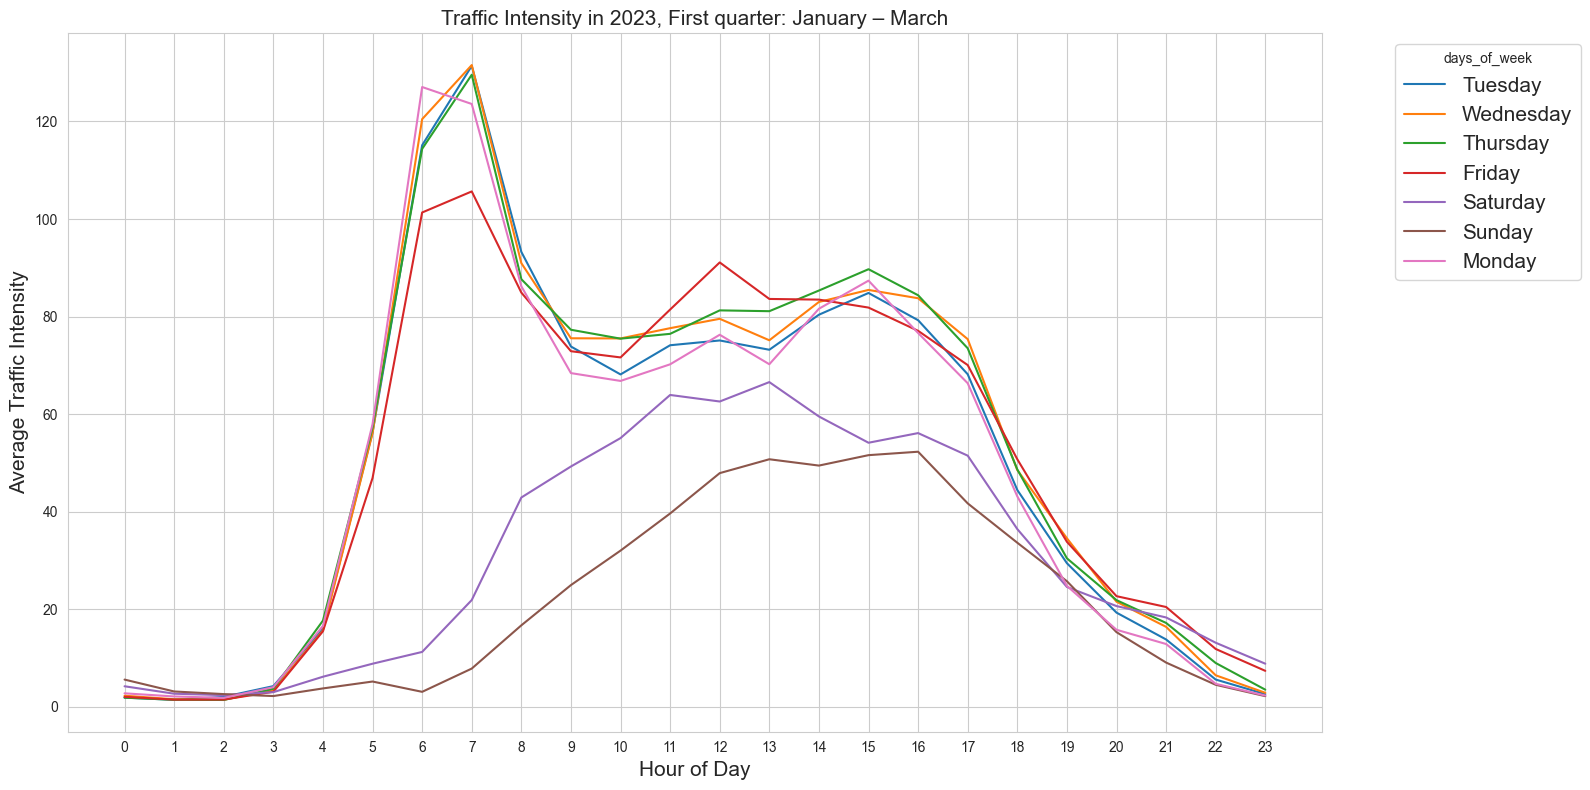

In [89]:
plt.figure(figsize=(16, 8))
sns.set_style("whitegrid")

sns.lineplot(x='hourOfDay', y='intensity', hue='days_of_week',
             data=data_preprocessed[data_preprocessed['month_number']<=3],
             estimator='mean', errorbar=None)

plt.title('Traffic Intensity in 2023, First quarter: January – March',fontsize = 15)
plt.xlabel('Hour of Day', fontsize = 15)
plt.ylabel('Average Traffic Intensity',fontsize = 15)
plt.xticks(range(0, 24))
plt.legend(title='days_of_week', bbox_to_anchor=(1.05, 1), loc='upper left',fontsize = 15)
plt.grid(True)
plt.tight_layout()

plt.show()

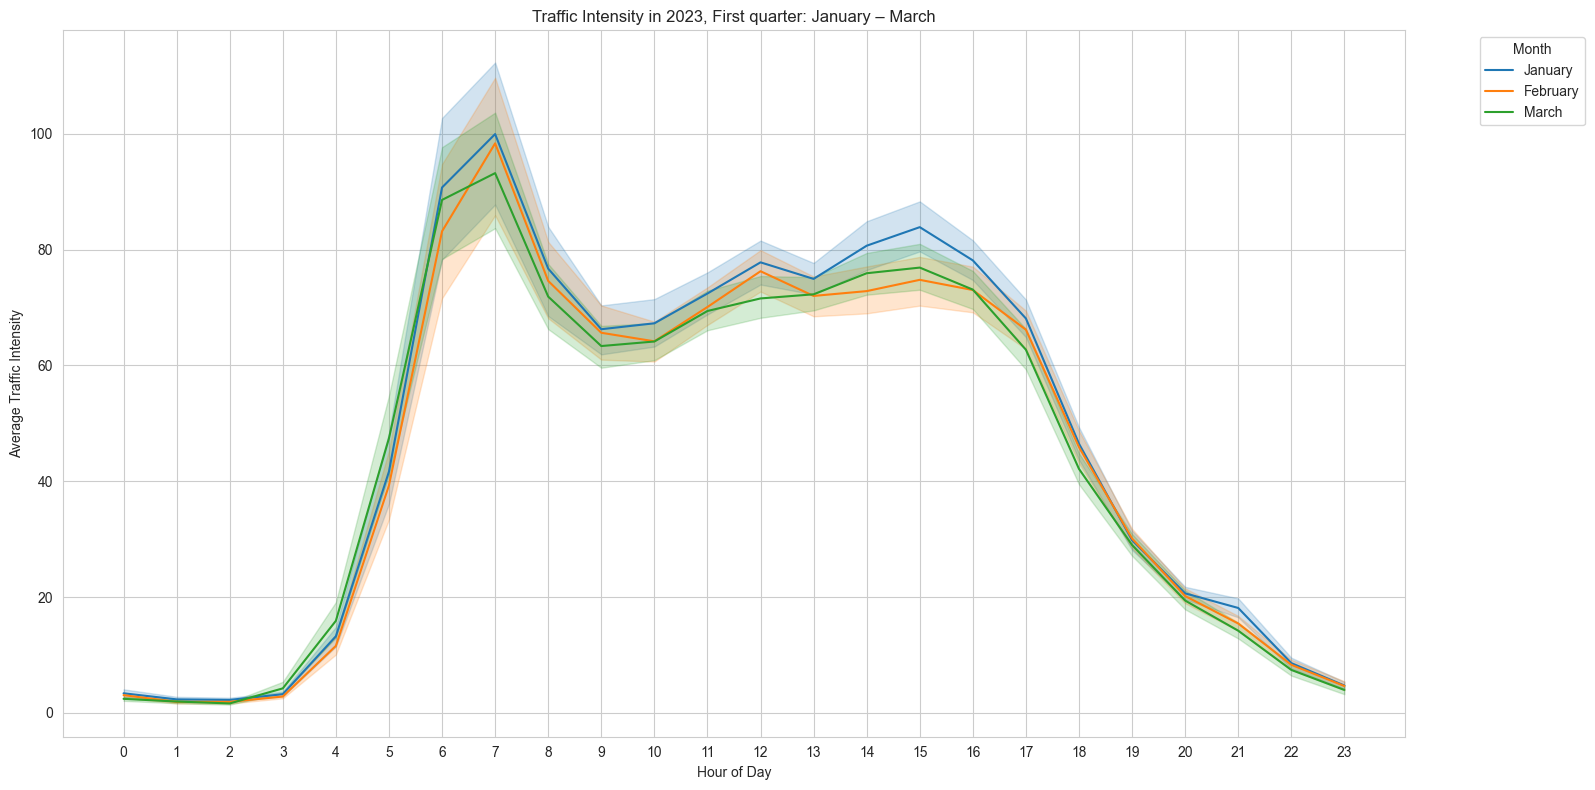

In [73]:
plt.figure(figsize=(16, 8))
sns.set_style("whitegrid")

sns.lineplot(x='hourOfDay', y='intensity', hue='month',
             data=data_preprocessed[(data_preprocessed['year'] == 2023) &(data_preprocessed['month_number']<=3)],
             estimator='mean')

plt.title(f'Traffic Intensity in 2023, First quarter: January – March')
plt.xlabel('Hour of Day')
plt.ylabel('Average Traffic Intensity')
plt.xticks(range(0, 24))
plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

plt.show()

#### One-hot encoding

In [74]:
data.vehicleType.unique()

array(['motorcycle', 'car', 'van', 'lorry'], dtype=object)

In [75]:
# One-hot encode 'vehicleType'
encoder = OneHotEncoder(sparse_output=False)
vehicle_type_encoded = encoder.fit_transform(data[['vehicleType']])
vehicle_type_encoded_df = pd.DataFrame(vehicle_type_encoded, columns=encoder.get_feature_names_out(['vehicleType']))

In [76]:
# One-hot encode locations
encoder = OneHotEncoder(sparse_output=False)
vehicle_type_encoded = encoder.fit_transform(data[['vehicleType']])
vehicle_type_encoded_df = pd.DataFrame(vehicle_type_encoded, columns=encoder.get_feature_names_out(['vehicleType']))

In [77]:
print(data.index.is_unique)
print(vehicle_type_encoded_df.index.is_unique)

True
True


In [78]:
data_vehicle_encoded= pd.concat([data, vehicle_type_encoded_df], axis=1)

#### Traffic intensity by vehicleType

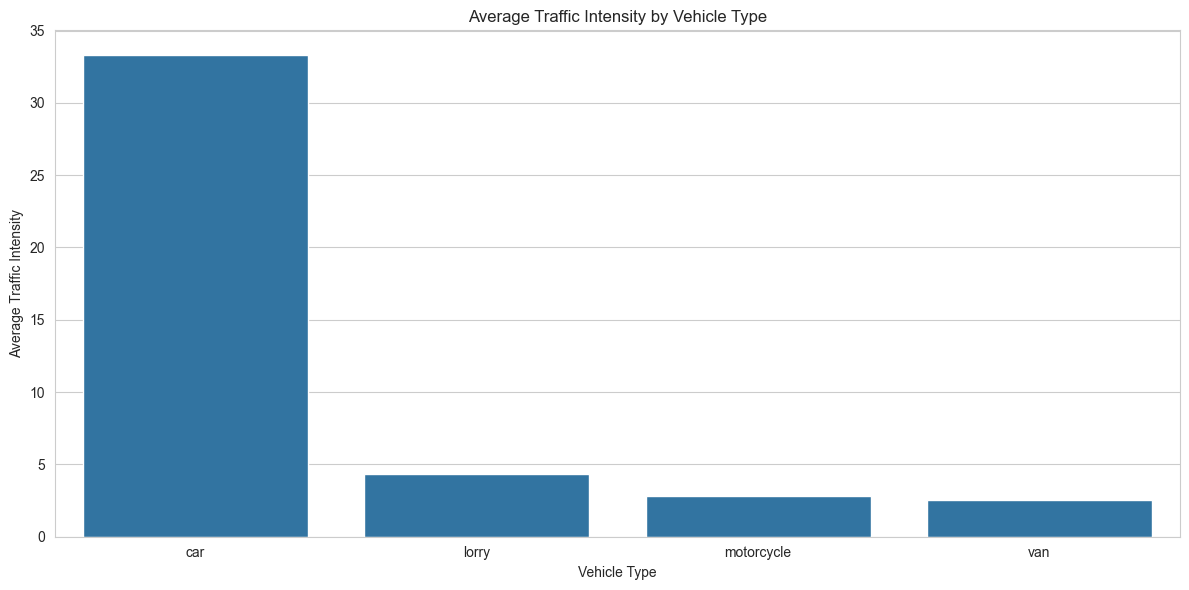

In [79]:
vehicle_types = encoder.categories_[0]
average_intensities = [data_vehicle_encoded.loc[data_vehicle_encoded[vehicle_type] == 1, 'intensity'].mean() for vehicle_type in vehicle_type_encoded_df.columns]
plt.figure(figsize=(12, 6))
sns.barplot(x=vehicle_types, y=average_intensities)
plt.title('Average Traffic Intensity by Vehicle Type')
plt.xlabel('Vehicle Type')
plt.ylabel('Average Traffic Intensity')
plt.tight_layout()
plt.show()